In [ ]:
!pip install pycocotools
!pip install gdown

  Installing build dependencies ... - \ | / - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp37-cp37m-linux_x86_64.whl size=373763 sha256=bccdd8fd17e718236a733d14adb56bb32f8fc700cbf40c52954b6ee3127fcda8
  Stored in directory: /root/.cache/pip/wheels/06/f6/f9/9cc49c6de8e3cf27dfddd91bf46595a057141d4583a2adaf03
Successfully built pycocotools
  Installing build dependencies ... - \ | done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for gdown: filename=gdown-4.5.3-py3-none-any.whl size=14821 sha256=906614ddb8a1fe9add65142af35ff50bcd9a5cb0ce441e4b29a7398f78fa5317
  Stored in directory: /root/.cache/pip/wheels/94/8d/0b/bdcd83555c3555f91a33f6c2384428d9f163c7d75ab0d272b4
Successfully built gdown


In [ ]:
import torch
import os

# DATASET

In [ ]:
import os
import cv2
import numpy as np
from pycocotools.coco import COCO
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
!unzip train_data.zip  -d train_data

Archive:  train_data.zip
   creating: train_data/train_data/
   creating: train_data/train_data/images/
   creating: train_data/train_data/images/train/
  inflating: train_data/train_data/images/train/1.jpg  
  inflating: train_data/train_data/images/train/10.jpg  
  inflating: train_data/train_data/images/train/11.jpg  
  inflating: train_data/train_data/images/train/12.jpg  
  inflating: train_data/train_data/images/train/13.jpg  
  inflating: train_data/train_data/images/train/14.jpg  
  inflating: train_data/train_data/images/train/15.jpg  
  inflating: train_data/train_data/images/train/16.jpg  
  inflating: train_data/train_data/images/train/17.jpg  
  inflating: train_data/train_data/images/train/18.jpg  
  inflating: train_data/train_data/images/train/19.jpg  
  inflating: train_data/train_data/images/train/2.jpg  
  inflating: train_data/train_data/images/train/20.jpg  
  inflating: train_data/train_data/images/train/21.jpg  
  inflating: train_data/train_data/images/train/22.

In [ ]:
dataset_name = "train_data"
train_images_path = "/content/train_data/train_data/images/train"
train_annotations_path = "/content/train_data/train_data/labels/train/train_json.json"
val_images_path = "/content/train_data/train_data/images/val"
val_annotations_path = "/content/train_data/train_data/labels/val/val_json.json"
register_coco_instances(f"{dataset_name}", {}, train_annotations_path, train_images_path)
register_coco_instances(f"{dataset_name}", {}, val_annotations_path, val_images_path)

# MODEL

In [ ]:
import torch
from tqdm import tqdm
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
def get_model():
    model = maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(
            in_features, num_classes=1+1)
    model.to(DEVICE)

    return model

In [ ]:
def save_checkpoint(state, filename="mask_rcnn.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [ ]:
def load_checkpoint(checkpoint, model, optimizer, lr):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [ ]:
if LOAD_MODEL and CHECKPOINT_FILE in os.listdir():
        print("Loading checkpoint")
        load_checkpoint(torch.load(CHECKPOINT_FILE), model, optimizer, LEARNING_RATE)

## Train

In [ ]:
train_dataset = DefaultTrainer(mode='train', augmentation=transform)
train_loader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=2,
                              pin_memory=PIN_MEMORY,
                              collate_fn=collate_fn)

valid_dataset = DefaultTrainer(mode='valid')
valid_loader = DataLoader(dataset=valid_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              pin_memory=PIN_MEMORY,
                              collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
def train_one_epoch(loader, model, optimizer, device):
    loop = tqdm(loader)

    for batch_idx, (images, targets) in enumerate(loop):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()



    print(f"Total loss: {losses.item()}")

In [ ]:
best_vloss = np.inf
def validate(loader, model, optimizer, device, epoch):
    global best_vloss
    loop = tqdm(loader)
    running_vloss = 0
    for batch_idx, (images, targets) in enumerate(loop):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
          loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        running_vloss += losses

    avg_vloss = running_vloss / (batch_idx + 1)

    print(f"Avg Valid Loss: {avg_vloss}")
    if avg_vloss < best_vloss:
      best_vloss = avg_vloss
      if SAVE_MODEL:
            print("Model improved, saving...")
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            save_checkpoint(checkpoint, filename=f"1152KaggleBest_second_{epoch}.pth.tar")
    print('\n')
    return avg_vloss

In [ ]:
model = get_model()
optimizer = torch.optim.AdamW(params=model.parameters(),
                                  lr=LEARNING_RATE,
                                  weight_decay=WEIGHT_DECAY)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [ ]:
model.train()
for epoch in range(NUM_EPOCHS):
                print(f"Epoch: {epoch}")
                train_one_epoch(train_loader, model, optimizer, DEVICE)
                vloss= validate(valid_loader, model, optimizer, DEVICE, epoch)

Epoch: 0


100%|██████████| 38/38 [00:59<00:00,  1.56s/it]


Total loss: 0.7763040065765381


100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


Avg Valid Loss: 0.5524086356163025


Epoch: 1


100%|██████████| 38/38 [00:52<00:00,  1.38s/it]


Total loss: 0.3665561079978943


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Avg Valid Loss: 0.40903210639953613


Epoch: 2


100%|██████████| 38/38 [00:52<00:00,  1.39s/it]


Total loss: 0.5053960084915161


100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


Avg Valid Loss: 0.3391428589820862


Epoch: 3


100%|██████████| 38/38 [00:52<00:00,  1.39s/it]


Total loss: 0.18668204545974731


100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


Avg Valid Loss: 0.2966099679470062


Epoch: 4


100%|██████████| 38/38 [00:53<00:00,  1.40s/it]


Total loss: 0.4047515392303467


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


Avg Valid Loss: 0.27707788348197937


Epoch: 5


100%|██████████| 38/38 [00:52<00:00,  1.39s/it]


Total loss: 0.21847845613956451


100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


Avg Valid Loss: 0.2750212252140045


Epoch: 6


100%|██████████| 38/38 [00:53<00:00,  1.40s/it]


Total loss: 0.2512308955192566


100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


Avg Valid Loss: 0.25783178210258484


Epoch: 7


100%|██████████| 38/38 [00:53<00:00,  1.42s/it]


Total loss: 0.3173721432685852


100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Avg Valid Loss: 0.2517615258693695


Epoch: 8


100%|██████████| 38/38 [00:53<00:00,  1.42s/it]


Total loss: 0.25057104229927063


100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


Avg Valid Loss: 0.2467379868030548


Epoch: 9


100%|██████████| 38/38 [00:53<00:00,  1.40s/it]


Total loss: 0.25404828786849976


100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Avg Valid Loss: 0.24233388900756836


Epoch: 10


100%|██████████| 38/38 [00:53<00:00,  1.42s/it]


Total loss: 0.1709970384836197


100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


Avg Valid Loss: 0.23591725528240204


Epoch: 11


100%|██████████| 38/38 [00:53<00:00,  1.40s/it]


Total loss: 0.2159067690372467


100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


Avg Valid Loss: 0.23154090344905853


Epoch: 12


100%|██████████| 38/38 [00:53<00:00,  1.42s/it]


Total loss: 0.19443856179714203


100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Avg Valid Loss: 0.2295435220003128


Epoch: 13


100%|██████████| 38/38 [00:53<00:00,  1.40s/it]


Total loss: 0.32309234142303467


100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


Avg Valid Loss: 0.22936177253723145


Epoch: 14


100%|██████████| 38/38 [00:53<00:00,  1.41s/it]


Total loss: 0.2152823656797409


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Avg Valid Loss: 0.23133623600006104


Epoch: 15


100%|██████████| 38/38 [00:53<00:00,  1.40s/it]


Total loss: 0.17070314288139343


100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Avg Valid Loss: 0.22618542611598969


Epoch: 16


100%|██████████| 38/38 [00:52<00:00,  1.39s/it]


Total loss: 0.16591587662696838


100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Avg Valid Loss: 0.22501568496227264


Epoch: 17


100%|██████████| 38/38 [00:52<00:00,  1.39s/it]


Total loss: 0.18335610628128052


100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


Avg Valid Loss: 0.21668271720409393


Epoch: 18


100%|██████████| 38/38 [00:53<00:00,  1.40s/it]


Total loss: 0.16762660443782806


100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Avg Valid Loss: 0.21635964512825012


Epoch: 19


100%|██████████| 38/38 [00:52<00:00,  1.39s/it]


Total loss: 0.21935027837753296


100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


Avg Valid Loss: 0.21821799874305725


Epoch: 20


100%|██████████| 38/38 [00:53<00:00,  1.39s/it]


Total loss: 0.21124330163002014


100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Avg Valid Loss: 0.21562008559703827


Epoch: 21


100%|██████████| 38/38 [00:53<00:00,  1.40s/it]


Total loss: 0.2208750993013382


100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Avg Valid Loss: 0.20932777225971222


Epoch: 22


100%|██████████| 38/38 [00:52<00:00,  1.39s/it]


Total loss: 0.2268459051847458


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Avg Valid Loss: 0.21966652572155


Epoch: 23


100%|██████████| 38/38 [00:52<00:00,  1.39s/it]


Total loss: 0.24384164810180664


100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Avg Valid Loss: 0.2154320776462555


Epoch: 24


100%|██████████| 38/38 [00:53<00:00,  1.40s/it]


Total loss: 0.23248399794101715


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Avg Valid Loss: 0.20825622975826263


Epoch: 25


100%|██████████| 38/38 [00:53<00:00,  1.40s/it]


Total loss: 0.354958713054657


100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Avg Valid Loss: 0.2053922414779663


Epoch: 26


100%|██████████| 38/38 [00:53<00:00,  1.40s/it]


Total loss: 0.24595272541046143


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Avg Valid Loss: 0.20674030482769012


Epoch: 27


100%|██████████| 38/38 [00:53<00:00,  1.41s/it]


Total loss: 0.21640124917030334


100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Avg Valid Loss: 0.20381899178028107


Epoch: 28


100%|██████████| 38/38 [00:52<00:00,  1.38s/it]


Total loss: 0.17734570801258087


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Avg Valid Loss: 0.20385293662548065


Epoch: 29


100%|██████████| 38/38 [00:52<00:00,  1.39s/it]


Total loss: 0.16835877299308777


100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

Avg Valid Loss: 0.19667427241802216




# TEST

In [ ]:
import cv2

In [ ]:
predictor = DefaultPredictor(model)

In [ ]:
test_image_path = "/content/train_data/train_data/images/train/19.jpg"
image = cv2.imread(test_image_path)
outputs = predictor(image)

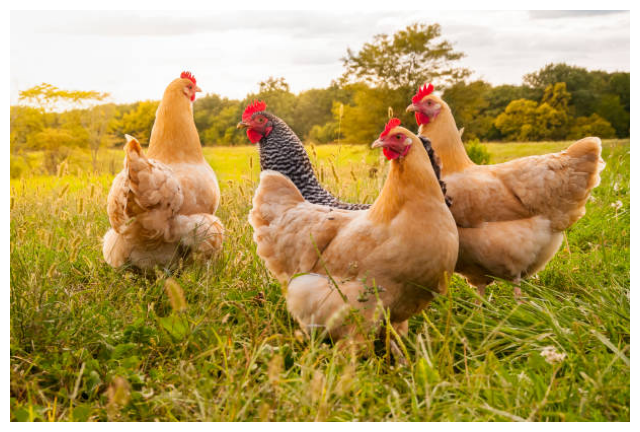

In [ ]:
import matplotlib.pyplot as plt
import cv2
image_path = "/content/train_data/train_data/images/train/5.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.show()


image 1/1 /content/5.jpg: 448x640 3 birds, 1 sheep, 250.0ms
Speed: 7.2ms preprocess, 250.0ms inference, 14.3ms postprocess per image at shape (1, 3, 448, 640)


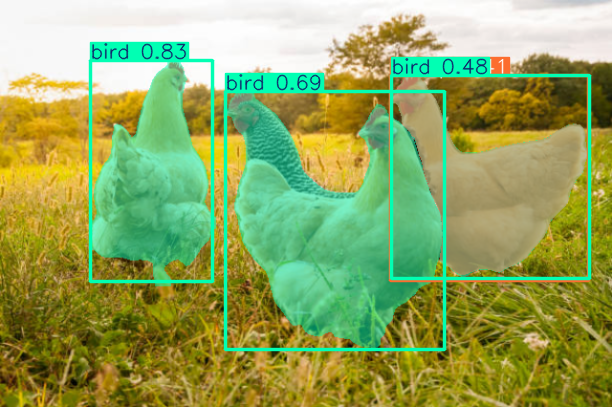

In [ ]:
v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(f"{dataset_name}_train"), scale=1.2)
output_image = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(12, 8))
plt.imshow(output_image.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()